# Practical session n°7 : Learning to Rank

Notions:
- learning to order things
- ranking function (or ranker)
- curriculum learning
- rank correlation(s)
- hinge loss and ranknet loss




Duration: 1 h 30

Several problems fall under the label "[learning-to-rank](https://link.springer.com/content/pdf/10.1007/978-3-642-15880-3_20.pdf)." One example is sorting a given list of labels (e.g. URL of websites) by relevance to an input query. This problem is referred to as *label ranking*.\
 In another scenario, input objects (e.g. images) should be sorted wrt a given criterion (e.g. 'foggy' or 'snowy'). Terms like *object ranking* and *learning to order things* are often used to describe this situation. In both cases, the learning is based on sorted samples, such as pairs of ordered images.

In this practical session, we illustrate the latter scenario using very simple synthetic images. All images consist of a mixture of a disc and a variable number of rectangles of different shapes. The goal is to sort the images based on the pixel intensity on the disc. To achieve this, we work in a standard context where we have pairs of ordered images. Using these pairs, we will train a neural network to construct a real-valued "ranking function" (*ranker*) whose outputs enable the sorting of images.

**Exercise 1:** Problem Construction

The following cells enable you to:
- generate a dataset on colab (train, val and test),
- define a dataset that provides pairs of images and a comparison based on the criterion of disc intensity ("0" if the disc is more intense in the first image, "1" otherwise),
- visualize an initial batch.

In [1]:
import os
from os.path import join
ls = lambda rep: sorted(os.listdir(rep))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.utils.data import Dataset, DataLoader, sampler

import matplotlib.pyplot as plt
import copy
from random import randint, choice

In [2]:
! git clone https://github.com/nanopiero/ML_S5_etudiants
! cp ML_S5_etudiants/practicals/P7/utils_P7.py .
from utils_P7 import *
root = r"/content"

Cloning into 'ML_S5_etudiants'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 193 (delta 37), reused 33 (delta 17), pack-reused 121 (from 1)
Receiving objects: 100% (193/193), 3.45 MiB | 19.63 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
dir_trainval = join(root, r"train")
generate_dataset(dir_trainval, size_dataset=10000)

dir_test = join(root, r"test")
generate_dataset(dir_test, size_dataset=2000)

In [5]:
# Retrieving target values

# Image paths:
dir_images_trainval = os.path.join(dir_trainval, 'images')
dir_images_test = os.path.join(dir_test, 'images')

# Target values for train+val
label_dict_path_trainval = os.path.join(dir_trainval, 'labels_synthese.pickle')
with open(label_dict_path_trainval, 'rb') as handle:
    label_dict_trainval = pickle.load(handle)

# Target values for test
label_dict_path_test = os.path.join(dir_test, 'labels_synthese.pickle')
with open(label_dict_path_test, 'rb') as handle:
    label_dict_test = pickle.load(handle)

# Splitting train / val (8000/2000)
all_image_names = np.array(ls(dir_images_trainval))

train_indices = list(range(0, 8000))
names_train = all_image_names[train_indices]
val_indices = list(range(8000, 10000))
names_val = all_image_names[val_indices]
names_test = ls(dir_images_test)

# Note: for random splitting, use sklearn.model_selection.train_test_split as tts

In [ ]:
# if error:
# from shutil import rmtree
# rmtree(dir_test)

In [6]:
# Data Augmentation
class SuperFlip(object):
    """
    The 8 transformations
    generated by R(Pi/2) and vertical symmetry/axis
    """
    def __init__(self, num_transforms):
        self.num_transforms = num_transforms

    def __call__(self, image):
        # Note: Ideally, torch.randint should be used here...
        n = randint(0, self.num_transforms)
        if n == 1:
            image = image.flip([1])
        elif n == 2:
            image = image.flip([2])
        elif n == 3:
            image = image.transpose(1, 2)
        elif n == 4:
            image = image.transpose(1, 2).flip([1])
        elif n == 5:
            image = image.transpose(1, 2).flip([2])
        elif n == 6:
            image = image.flip([1, 2])
        elif n == 7:
            image = image.transpose(1, 2).flip([1, 2])
        return image

super_flip_transform = SuperFlip(8)

transforms = {
    'train': super_flip_transform,
    'val': None,
    'test': None
}

In [7]:
# Dataset Construction:
def oracle(name0, name1, data_dict):
    # Load the data:
    y0 = data_dict[name0]['y']
    y1 = data_dict[name1]['y']

    # Determine the comparison:
    compa = 0 if y1 < y0 else 1
    return compa

class DatasetOrderedPairs(torch.utils.data.Dataset):
    def __init__(self, images_dir, data_dict, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.imgs = ls(images_dir)
        self.data_dict = data_dict

    def __getitem__(self, idx):
        name0 = self.imgs[idx]
        name1 = choice(self.imgs)
        label = oracle(name0, name1, self.data_dict)

        # Get the images
        path0 = os.path.join(self.images_dir, name0)
        img0 = torch.load(path0, weights_only=True)
        path1 = os.path.join(self.images_dir, name1)
        img1 = torch.load(path1, weights_only=True)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array(label)).long(), name0, name1   # -1 if no class 0

    def __len__(self):
        return len(self.imgs)

In [8]:
# Dataset instantiation:
dataset_train = DatasetOrderedPairs(dir_images_trainval, label_dict_trainval, transforms['train'])
dataset_val = DatasetOrderedPairs(dir_images_trainval, label_dict_trainval, transforms['val'])
dataset_test = DatasetOrderedPairs(dir_images_test, label_dict_test, transforms['test'])

datasets = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

In [9]:
# Samplers and loaders
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

samplers = {'train': train_sampler, 'val': val_sampler}

batch_size = 64

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=False, sampler=samplers[x], num_workers=2) for x in ['train', 'val']}
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'], batch_size=batch_size, shuffle=False, num_workers=0)
dataset_sizes = {'train': len(names_train), 'val': len(names_val), 'test': len(names_test)}

dataloaders['viz'] = torch.utils.data.DataLoader(datasets['train'], batch_size=6, shuffle=False, num_workers=0)

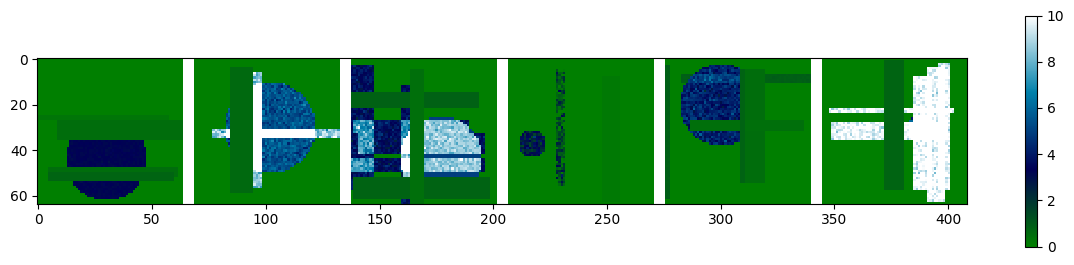

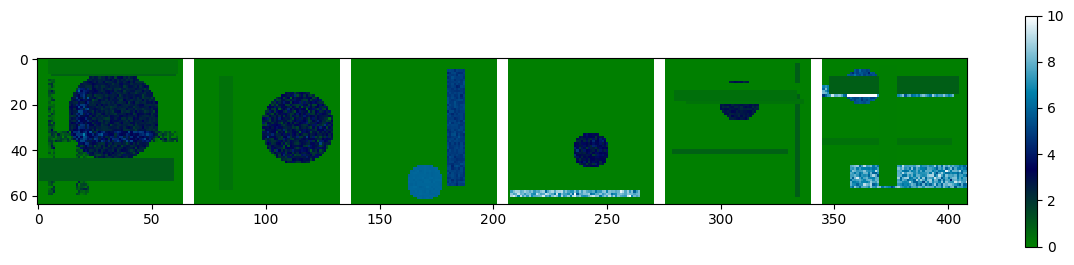

tensor([0, 0, 1, 1, 0, 1])


In [10]:
# Visualisation

img1, img2, labels, _, _ = next(iter(dataloaders['viz']))

fig0 = plt.figure(0, figsize=(15, 3))
voir_batch2D(img1, nx = 8, fig = fig0, k=0, min_scale=0,max_scale=10)
fig1 = plt.figure(1, figsize=(15, 3))
voir_batch2D(img2, nx = 8, fig = fig1, k=0, min_scale=0,max_scale=10)

print(labels)


**Q0** How is done the separation between training and validation done here?

**Q1** What is the role of *super_flip*? And that of the *oracle* function?

**Q2** Are all pairs of images equally easy to order?

**Exercise 2:** Siamese Learning

During training, batches of image pairs are compared. Basic siamese network training involves passing each image in the pair independently through the model and penalizing the model when the outputs are arranged in the wrong order.

The simplest way to do this is to consider the positive part of the difference between the outputs. This is what the following cost function does:

In [12]:
# Hinge Loss function

def label_to_sgn(label):  # 0 -> 1  and 1 -> -1
    sgn = torch.where(label == 0, 1, -1)
    return sgn

class HingeLoss(torch.nn.Module):
    def __init__(self, margin=0.1):
        super(HingeLoss, self).__init__()
        self.margin = margin

    def forward(self, output0, output1, label):
        sgn = label_to_sgn(label)
        diff = sgn * (output1 - output0)

        loss = torch.relu(diff + self.margin).mean()
        return loss

**Q1** Write the training loop and run it for 20 epochs. Keep track of the successive accuracies.

In [13]:
num_epochs = 20
channels = 1

# With a ResNet18
from torchvision.models import resnet18
model = resnet18(num_classes=1)
print(model.inplanes)
model.conv1 =  nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
nn.init.kaiming_normal_( model.conv1.weight, mode="fan_out", nonlinearity="relu")


device = torch.device("cuda:0")
model = model.to(device)




# Loss function and optimizer
criterion = HingeLoss(margin=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)



512


In [20]:
from tqdm import tqdm, notebook


train_accs = []
val_accs = []

phases = ['train', 'val']

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in phases:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        data_loader = notebook.tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}', leave= phase == 'train')
        # Iterate over data.
        for img1, img2, labels, _, _ in data_loader:
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device).detach()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                output1 = model(img1)
                output2 = model(img2)
                loss = criterion(output1, output2, labels.to(torch.float32).unsqueeze(dim=1))
                preds = (output1 > output2).long()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * img1.size(0)
            running_corrects += torch.sum(preds == labels.data).double().item()

            data_loader.set_postfix(loss=f'{loss.item():.4f}', refresh=False)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_accs.append(epoch_acc)

        if phase == 'val':
            val_accs.append(epoch_acc)


Epoch 1/20
----------


Train Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0624 Acc: 31.7715


Val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0472 Acc: 31.4290
Epoch 2/20
----------


Train Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0431 Acc: 31.8885


Val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0396 Acc: 31.6310
Epoch 3/20
----------


Train Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0405 Acc: 31.7850


Val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0341 Acc: 31.4470
Epoch 4/20
----------


Train Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0381 Acc: 31.8102


Val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0388 Acc: 31.3000
Epoch 5/20
----------


Train Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0345 Acc: 31.8310


Val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0432 Acc: 31.4230
Epoch 6/20
----------


Train Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0345 Acc: 31.8275


Val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0347 Acc: 31.3430
Epoch 7/20
----------


Train Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0336 Acc: 31.8815


Val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0296 Acc: 31.3850
Epoch 8/20
----------


Train Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0320 Acc: 31.6958


Val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0314 Acc: 31.3200
Epoch 9/20
----------


Train Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0319 Acc: 31.7737


Val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0315 Acc: 31.3220
Epoch 10/20
----------


Train Epoch 9:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0291 Acc: 31.7840


Val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0302 Acc: 31.5720
Epoch 11/20
----------


Train Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0297 Acc: 31.7650


Val Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0301 Acc: 31.3110
Epoch 12/20
----------


Train Epoch 11:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0287 Acc: 31.7440


Val Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0278 Acc: 31.3720
Epoch 13/20
----------


Train Epoch 12:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0282 Acc: 31.6910


Val Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0243 Acc: 31.3550
Epoch 14/20
----------


Train Epoch 13:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0277 Acc: 31.6442


Val Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0297 Acc: 31.5170
Epoch 15/20
----------


Train Epoch 14:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0266 Acc: 31.7748


Val Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0207 Acc: 31.5170
Epoch 16/20
----------


Train Epoch 15:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0261 Acc: 31.7755


Val Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0260 Acc: 31.4260
Epoch 17/20
----------


Train Epoch 16:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0256 Acc: 31.6343


Val Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0290 Acc: 31.3510
Epoch 18/20
----------


Train Epoch 17:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0260 Acc: 31.6973


Val Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0263 Acc: 31.5090
Epoch 19/20
----------


Train Epoch 18:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0251 Acc: 31.6947


Val Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0239 Acc: 31.4900
Epoch 20/20
----------


Train Epoch 19:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0240 Acc: 31.7385


Val Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0220 Acc: 31.3460


**Q3** Check the learning curve.

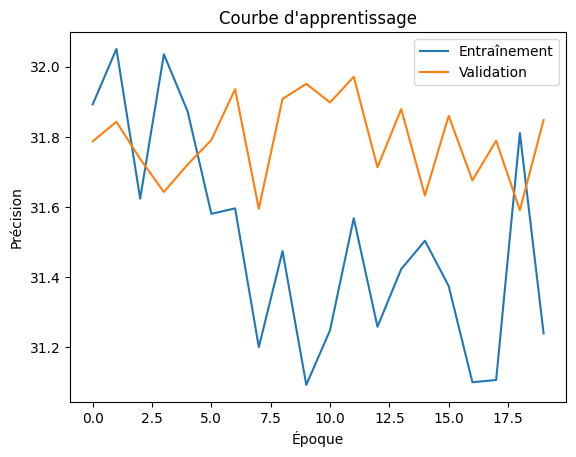

In [18]:
import matplotlib.pyplot as plt

plt.plot(train_accs, label='Entraînement')
plt.plot(val_accs, label='Validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.title('Courbe d\'apprentissage')
plt.legend()
plt.show()

**Q4** Interprete the following scatterplot:

<ipython-input-17-ab3c4830db92>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(path)


Text(0, 0.5, '$\\hat{y}$')

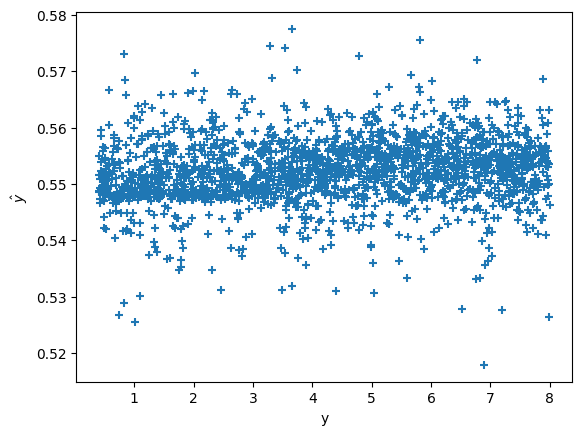

In [17]:
# true (mean) pixel intensity on the disk:
ys = []
# outputs of the network:
yhats = []

# browse the test set:
for name in names_test:
    # get true mean intensity on the disk
    y = label_dict_test[name]['y']
    ys.append(y)

    path = join(dir_images_test, name)
    image = torch.load(path)
    image = image.cuda().unsqueeze(dim=0)

    # get model output
    yhat = model.eval()(image)
    yhat = yhat.item()
    yhats.append(yhat)

# make np array
ys = np.array(ys)
yhats = np.array(yhats)

# scatterplot
plt.figure(num=10)
plt.scatter(ys, yhats, marker='+')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')


**Q5** Calculate the Spearman and Kendall rank correlations. Which of the two is related to the accuracy measure?


**Q6** How would you improve performance ?

**Exercice 3** Curriculum Learning

One idea is to make the problem harder after an initial training phase. The following code allows you to retrieve a ResNet18 trained for 50 epochs, the optimizer, and the associated learning curve:

In [ ]:
! pip install huggingface_hub
from huggingface_hub import hf_hub_download
model_hf_name = "resnet18_50ep.checkpoint"
PATH_checkpoint = hf_hub_download(repo_id="nanopiero/models_ML_S5_P7", filename=model_hf_name)

**Q1** Continue training for an additional 20 epochs without changing the dataloader. Remember to store accuracies related to the validation set and outputs related to the test set.

**Q2** We will now continue training on pairs that are harder to order. For this purpose, we have the 'Dataset_finer_pairs' dataset below. Train for 20 epochs using this dataset.

In [ ]:
def make_dic_ray(imgs, dic, ray):

  ys = np.array([dic[img]['y'] for img in imgs])
  imgs = np.array(imgs)
  dic_ray = {}
  for i,img in enumerate(imgs):
    y = ys[i]
    # on limite la paire à des disques proches en intensité
    dic_ray[img] = list(imgs[np.abs(ys - y) < ray])

  return dic_ray

class Dataset_finer_pairs(torch.utils.data.Dataset):
    def __init__(self, images_dir,  dic, transfo = None, ray=0.5):
        self.images_dir = images_dir
        self.transfo = transfo
        self.imgs = sorted(ls(images_dir))
        self.dic = dic
        self.dic_ray = make_dic_ray(self.imgs, dic, ray)

    def __getitem__(self,idx):

        name0 = self.imgs[idx]
        name1 = choice(self.dic_ray[name0])
        label = oracle(name0, name1, self.dic)


        #get the images
        path0 = os.path.join(self.images_dir, name0)
        img0 =  torch.load(path0, weights_only=True)
        path1 = os.path.join(self.images_dir, name1)
        img1 = torch.load(path1, weights_only=True)


        if self.transfo is not None:
            img0 = self.transfo(img0)
            img1 = self.transfo(img1)

        return img0, img1,  torch.from_numpy(np.array(label)).long(), name0, name1

    def __len__(self):
        return len(self.imgs)

**Q3** Compare the learning curves (training and validation accuracies) and the results on the test set. Discuss.

**Exercise 4** RankNet Loss

A milder version of the Hinge Loss has been widely used, particularly in search engine learning, known as the RankNet Loss.

This cost function is derived from a parametric probabilistic model, the [Bradley-Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model).

In a general version, it is assumed that the outcome of a comparison (or match) between two objects "0" and "1" (or two teams) is random and depends on real values associated with the objects (the "team levels") as follows:
\begin{align}
P_0 = \dfrac{f(y_0)}{f(y_0) + f(y_1)}
\tag{1}
\end{align}
Where $P_0$ is the probability of choosing object "0" (or the first team winning), and $f$ is a strictly increasing function with positive values.

**Q1** In the case where $f(y) = e^{\sigma y}$, what do the choice probabilities depend on? Write the log-likelihood of the event "object $x$ is chosen."

Dans le cas où $f(y) = e^{\sigma y}$, les probabilités de choix dépendent uniquement de la différence $y_1 - y_0$. Lorsque des matchs sont joués, la valeur la plus vraisemblable de $y$ est interprétée comme le "niveau" d'un joueur (voir [classement Elo](https://fr.wikipedia.org/wiki/Classement_Elo)).

**Q2** Derive an appropriate cost function for our ranking problem based on the given log-likelihood.

Under this model, the log-likelihood of the choice $c$ between two objects 0 and 1 is given by:
$$ \delta_{c=0} \; \ln \left[ \frac{e^{\sigma y_0}}{e^{\sigma y_0} + e^{\sigma y_1}} \right] + \delta_{c=1} \; \ln \left[ \frac{e^{\sigma y_1}}{e^{\sigma y_0} + e^{\sigma y_1}} \right] $$

To constrain the network to order objects based on whether they are chosen or not by the annotator on a given criterion, one can seek to maximize the log-likelihood, which is equivalent to minimizing the following cost function (equality left as an exercise):

$$ \mathcal{L}(y_0, y_1, c \; ; \sigma) = - \delta_{c=1} \; \sigma \; (y_1 - y_0) \; + \; \ln(1 + e^{\sigma (y_1 - y_0)})  $$

**Q3** Implement and compare over twenty epochs with a VGG11.

In [ ]:
from torchvision import models
vgg11 = models.vgg11(pretrained=False)